In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [2]:
power = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data.txt",names=["power_demand"])


In [3]:
sub_power = pd.Series(power[490:51*84*8+490].reset_index(drop=True)["power_demand"])
sub_power = sub_power[::8].reset_index(drop=True)
sub_power = sub_power.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(sub_power)
sub_power = scaler.transform(sub_power) 

sub_power_ = np.array([sub_power[t][0] for t in range(sub_power.shape[0])])
sub_power_list = [sub_power_[t*84:(t+1)*84] for t in range(51)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
anomalous_indices = [11,12,16,17,19,38,50]
normal_indices = list(set(range(51))-set(anomalous_indices))
dataset_normal = [sub_power_list[i] for i in normal_indices]
dataset_anomalous = [sub_power_list[j] for j in anomalous_indices]

In [5]:
label = np.array(['anomaly' for _ in range(51)])
label[normal_indices] = 'normal'
label = [[x]*84 for x in label]
label = np.array(label).ravel()

In [6]:
sub_power.shape

(4284, 1)

In [7]:
data = pd.concat((pd.DataFrame(sub_power),pd.Series(label)),axis=1)

In [8]:
#data.to_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data_labeled_unscaled.csv",header=None,index=None)

In [9]:
test_set = data[1008:]


# Autoencoder anomaly detection

In [10]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

## Reload power_demand autoencoder from disk

In [11]:
#modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try1_2_40_84/"
modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try6_1_40_84/"
modelmeta_p = modelpath_root + "LSTMAutoencoder_power_1_40_84_para.ckpt.meta"
step_num = 84
hidden_num = 40
batch_num = 1
elem_num = 1

In [12]:
#test_set_list = [test_set.iloc[:3192,0].as_matrix().reshape(19,2,84,1)[a] for a in range(19)]
test_set_list = [test_set.iloc[:,0].as_matrix().reshape(39,1,84,1)[a] for a in range(39)]

In [13]:
sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
#        p_is_training = tf.placeholder(tf.bool)
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try6_1_40_84/LSTMAutoencoder_power_1_40_84_para.ckpt


# Retrain according to performance

## 1. retrain when error.max >= err.max[0]

Retrain at batch number 1

Retrain-iter 1: 0.0117949
Retrain-iter 2: 0.0109062
Retrain-iter 3: 0.00923583
Retrain-iter 4: 0.00783146
Retrain-iter 5: 0.00707266
Retrain-iter 6: 0.00692838
Retrain-iter 7: 0.00720185
Retrain-iter 8: 0.0076523
Retrain-iter 9: 0.00804212
Retrain-iter 10: 0.00816225
Retrain-iter 11: 0.00790183
Retrain-iter 12: 0.00734136
Retrain-iter 13: 0.00673846
Retrain-iter 14: 0.00635809
Retrain-iter 15: 0.00630616
Retrain-iter 16: 0.00650932
Retrain-iter 17: 0.00679254
Retrain-iter 18: 0.00697163
Retrain-iter 19: 0.00693525
Retrain-iter 20: 0.00669581
Retrain-iter 21: 0.0063808
Retrain-iter 22: 0.00615473
Retrain-iter 23: 0.0061067
Retrain-iter 24: 0.00619089
Retrain-iter 25: 0.0062872
Retrain-iter 26: 0.00631863
Retrain-iter 27: 0.0062897
Retrain-iter 28: 0.00623288
Retrain-iter 29: 0.00616311
Retrain-iter 30: 0.00608527
Retrain-iter 31: 0.00601501
Retrain-iter 32: 0.00597604
Retrain-iter 33: 0.00597887
Retrain-iter 34: 0.00600667
Retrain-iter 35: 0.00602616
Retrain-i

Retrain-iter 288: 0.00504396
Retrain-iter 289: 0.00504092
Retrain-iter 290: 0.00503788
Retrain-iter 291: 0.00503483
Retrain-iter 292: 0.00503179
Retrain-iter 293: 0.00502873
Retrain-iter 294: 0.00502568
Retrain-iter 295: 0.00502262
Retrain-iter 296: 0.00501955
Retrain-iter 297: 0.00501648
Retrain-iter 298: 0.00501341
Retrain-iter 299: 0.00501033
Retrain-iter 300: 0.00500725
Retrain-iter 301: 0.00500416
Retrain-iter 302: 0.00500107
Retrain-iter 303: 0.00499798
Retrain-iter 304: 0.00499488
Retrain-iter 305: 0.00499177
Retrain-iter 306: 0.00498866
Retrain-iter 307: 0.00498555
Retrain-iter 308: 0.00498243
Retrain-iter 309: 0.00497931
Retrain-iter 310: 0.00497618
Retrain-iter 311: 0.00497305
Retrain-iter 312: 0.00496991
Retrain-iter 313: 0.00496677
Retrain-iter 314: 0.00496363
Retrain-iter 315: 0.00496048
Retrain-iter 316: 0.00495732
Retrain-iter 317: 0.00495415
Retrain-iter 318: 0.00495099
Retrain-iter 319: 0.00494781
Retrain-iter 320: 0.00494464
Retrain-iter 321: 0.00494146
Retrain-iter 3

Retrain-iter 81: 0.00602857
Retrain-iter 82: 0.00545344
Retrain-iter 83: 0.00447429
Retrain-iter 84: 0.00410813
Retrain-iter 85: 0.00465725
Retrain-iter 86: 0.00412241
Retrain-iter 87: 0.00580826
Retrain-iter 88: 0.00625235
Retrain-iter 89: 0.00609755
Retrain-iter 90: 0.00396916
Retrain-iter 91: 0.00392458
Retrain-iter 92: 0.00422329
Retrain-iter 93: 0.00363872
Retrain-iter 94: 0.00718634
Retrain-iter 95: 0.0042273
Retrain-iter 96: 0.00331689
Retrain-iter 97: 0.00450989
Retrain-iter 98: 0.00686951
Retrain-iter 99: 0.00352392
Retrain-iter 100: 0.00398186
Retrain-iter 101: 0.00419285
Retrain-iter 102: 0.00387472
Retrain-iter 103: 0.00735861
Retrain-iter 104: 0.00598397
Retrain-iter 105: 0.00693196
Retrain-iter 106: 0.00657109
Retrain-iter 107: 0.00560108
Retrain-iter 108: 0.00440507
Retrain-iter 109: 0.0043958
Retrain-iter 110: 0.00422753
Retrain-iter 111: 0.00439866
Retrain-iter 112: 0.00433544
Retrain-iter 113: 0.00433129
Retrain-iter 114: 0.00688441
Retrain-iter 115: 0.00355051
Retrai

Retrain-iter 372: 0.00324679
Retrain-iter 373: 0.00319227
Retrain-iter 374: 0.00366074
Retrain-iter 375: 0.00623666
Retrain-iter 376: 0.00380853
Retrain-iter 377: 0.00282161
Retrain-iter 378: 0.00354141
Retrain-iter 379: 0.00370735
Retrain-iter 380: 0.00371411
Retrain-iter 381: 0.00309237
Retrain-iter 382: 0.00429521
Retrain-iter 383: 0.00514291
Retrain-iter 384: 0.00337565
Retrain-iter 385: 0.00328366
Retrain-iter 386: 0.00434629
Retrain-iter 387: 0.00683517
Retrain-iter 388: 0.00410093
Retrain-iter 389: 0.00443784
Retrain-iter 390: 0.00367461
Retrain-iter 391: 0.00353477
Retrain-iter 392: 0.00512024
Retrain-iter 393: 0.00372602
Retrain-iter 394: 0.00387078
Retrain-iter 395: 0.00533204
Retrain-iter 396: 0.0037947
Retrain-iter 397: 0.00393285
Retrain-iter 398: 0.00336829
Retrain-iter 399: 0.00297579
Retrain-iter 400: 0.0037046
Retrain-iter 401: 0.00463876
Retrain-iter 402: 0.00671147
Retrain-iter 403: 0.00279955
Retrain-iter 404: 0.0034135
Retrain-iter 405: 0.00332747
Retrain-iter 406:

Retrain-iter 164: 0.00463345
Retrain-iter 165: 0.00585173
Retrain-iter 166: 0.00295628
Retrain-iter 167: 0.00402869
Retrain-iter 168: 0.00293277
Retrain-iter 169: 0.00573805
Retrain-iter 170: 0.00458292
Retrain-iter 171: 0.00334872
Retrain-iter 172: 0.00295426
Retrain-iter 173: 0.00765642
Retrain-iter 174: 0.00799139
Retrain-iter 175: 0.00496942
Retrain-iter 176: 0.00339414
Retrain-iter 177: 0.00611243
Retrain-iter 178: 0.00449934
Retrain-iter 179: 0.00496213
Retrain-iter 180: 0.00636847
Retrain-iter 181: 0.00597839
Retrain-iter 182: 0.00332556
Retrain-iter 183: 0.00315675
Retrain-iter 184: 0.0062226
Retrain-iter 185: 0.00299867
Retrain-iter 186: 0.00294265
Retrain-iter 187: 0.00289905
Retrain-iter 188: 0.00310996
Retrain-iter 189: 0.00362827
Retrain-iter 190: 0.00514418
Retrain-iter 191: 0.00325018
Retrain-iter 192: 0.00516835
Retrain-iter 193: 0.0035659
Retrain-iter 194: 0.00692668
Retrain-iter 195: 0.00604034
Retrain-iter 196: 0.00341968
Retrain-iter 197: 0.00379917
Retrain-iter 198

Retrain-iter 455: 0.00497315
Retrain-iter 456: 0.0042454
Retrain-iter 457: 0.00600003
Retrain-iter 458: 0.00486817
Retrain-iter 459: 0.00370105
Retrain-iter 460: 0.00345525
Retrain-iter 461: 0.00281359
Retrain-iter 462: 0.00528218
Retrain-iter 463: 0.00480745
Retrain-iter 464: 0.00331641
Retrain-iter 465: 0.00435481
Retrain-iter 466: 0.00248395
Retrain-iter 467: 0.00432409
Retrain-iter 468: 0.0028
Retrain-iter 469: 0.00298042
Retrain-iter 470: 0.00295386
Retrain-iter 471: 0.00313747
Retrain-iter 472: 0.00455552
Retrain-iter 473: 0.00512041
Retrain-iter 474: 0.00655038
Retrain-iter 475: 0.00434754
Retrain-iter 476: 0.00311026
Retrain-iter 477: 0.00407131
Retrain-iter 478: 0.00273239
Retrain-iter 479: 0.0030696
Retrain-iter 480: 0.00648369
Retrain-iter 481: 0.00594755
Retrain-iter 482: 0.00476448
Retrain-iter 483: 0.00268909
Retrain-iter 484: 0.00288661
Retrain-iter 485: 0.00485463
Retrain-iter 486: 0.0046303
Retrain-iter 487: 0.00366973
Retrain-iter 488: 0.00224232
Retrain-iter 489: 0.0

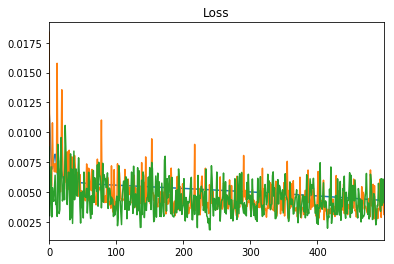

In [14]:
input_buffer = []
output_buffer = []
#anomaly_batches = [0,2,3,18]
anomaly_batches = [3,4,6,25,37]
count = -1 # jump the anomaly batches, not used for retraining
loss_overall = []
err_max_0 = 0
dataBuffer = []

for data in test_set_list:
    count +=1
    
    
    (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})
    input_buffer.append(input_n)
    output_buffer.append(output_n)
    if count in anomaly_batches: 
        continue    
    else:
        dataBuffer.append(data)
        
    if count == 1:
        err_max_0 = max(abs(input_n- output_n).ravel())
        
    # retrain 
    error_max = max(abs(input_n-output_n).ravel())
    if error_max >= err_max_0:
        print("Retrain at batch number %d\n"%count)
        loss = []
        for i in range(500):
            ind = np.random.randint(0,len(dataBuffer))
            d = dataBuffer[ind]
            (loss_val, _) = sess.run([loss_, train_], {p_input: d,p_is_training : True})
            loss.append(loss_val)
            print('Retrain-iter %d:' % (i + 1), loss_val)
        loss_overall.append(loss_val)
        pd.Series(loss).plot(title="Loss")
        dataBuffer.clear()

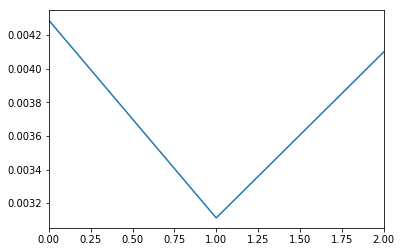

In [15]:
pd.Series(loss_overall).plot()

In [16]:
foo = pd.Series(np.array(input_buffer).ravel())
bar = pd.Series(np.array(output_buffer).ravel())
foobar = pd.concat((foo,bar),axis=1)

foobar.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv",header=['input','output'],index=None)

Normal: Max 0.44, min 0.00, avg 0.07, median 0.06
Abnormal: Max 0.66, min 0.00, avg 0.13, median 0.08


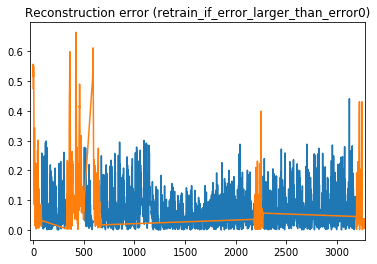

In [17]:
# reconstruction error of normal data(retrain after each batch)

normal =pd.DataFrame( foobar[label[1008:]== 'normal'])
abnormal =pd.DataFrame( foobar[label[1008:]== 'anomaly'])

error1 = abs( normal[0]- normal[1])
error2 = abs( abnormal[0]- abnormal[1])
error1.plot()
error2.plot()
plt.xlim(-30,error1.size+error2.size)
plt.title("Reconstruction error (retrain_if_error_larger_than_error0)")
print("Normal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error1),min(error1), np.mean(error1),np.median(error1)))
print("Abnormal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error2),min(error2), np.mean(error2),np.median(error2)))

In [18]:
# statistical results in batch
normal_batches = [error1[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error1.size//(batch_num*step_num))]
abnormal_batches = [error2[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error2.size//(batch_num*step_num))]

batch_error1  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in normal_batches])
batch_error2  = pd.DataFrame([[max(y),min(y),np.mean(y),np.median(y)] for y in abnormal_batches])

batch_error1.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/normal_retraining(batch).csv",header=['max','min','avg','median'],index=None)
batch_error2.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/abnormal_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [19]:
error0 =  abs( foobar[0]- foobar[1])
all_batches = [error0[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error0.size//(batch_num*step_num))]
batch_error0  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in all_batches])
batch_error0.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/all_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [20]:
data = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv")

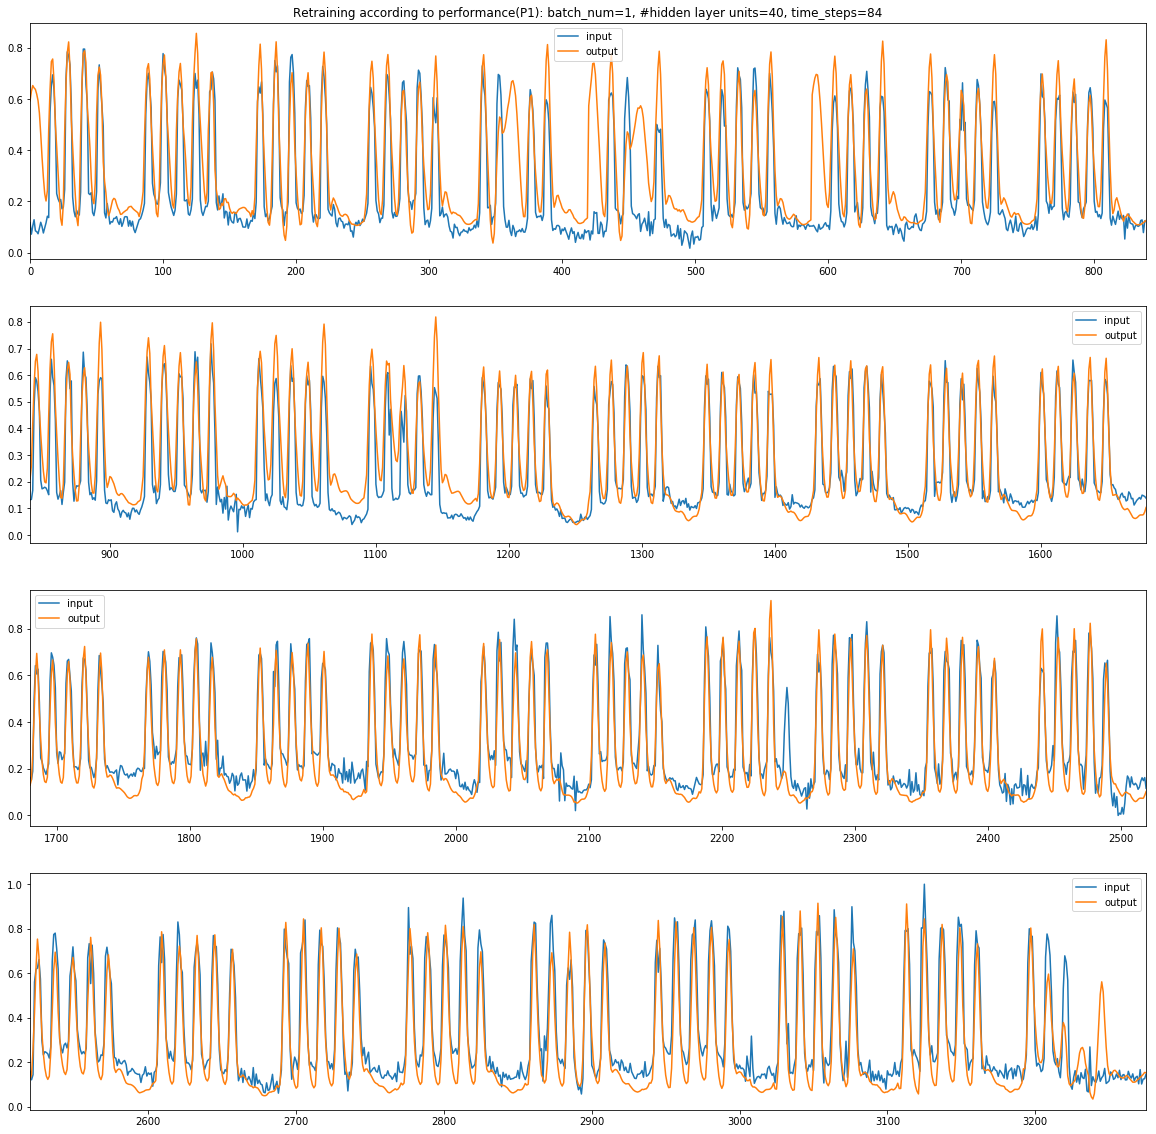

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(20,20))
axes[0].set_title("Retraining according to performance(P1): batch_num=1, #hidden layer units=40, time_steps=84")
data[:840].plot(ax=axes[0])
data[840*1:840*2].plot(ax=axes[1])
data[840*2:840*3].plot(ax=axes[2])
data[840*3:].plot(ax=axes[3])


(0, 1)

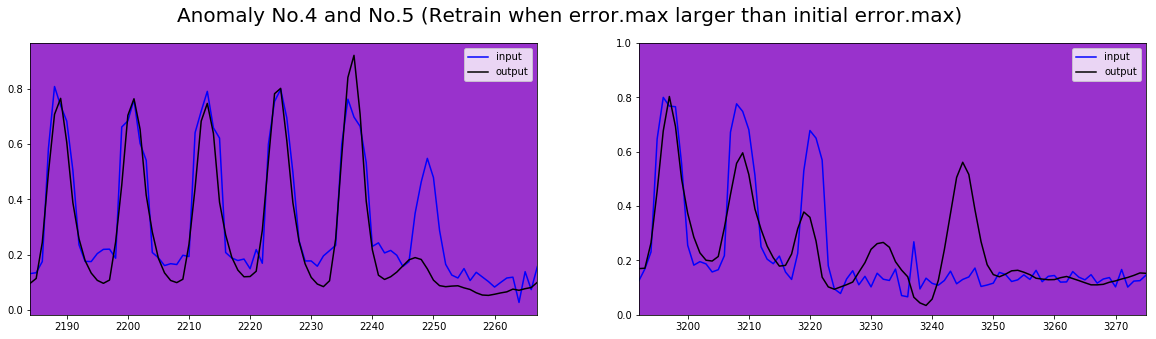

In [24]:
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
plt.suptitle("Anomaly No.4 and No.5 (Retrain when error.max larger than initial error.max)", fontsize=20)
data[84*26:84*27].plot(ax=ax0,color=['blue','black'])
data[-84:].plot(ax=ax1,color=['blue','black'])
ax0.set_facecolor('darkorchid')
ax1.set_facecolor('darkorchid')
plt.ylim(0,1)

(0, 0.8)

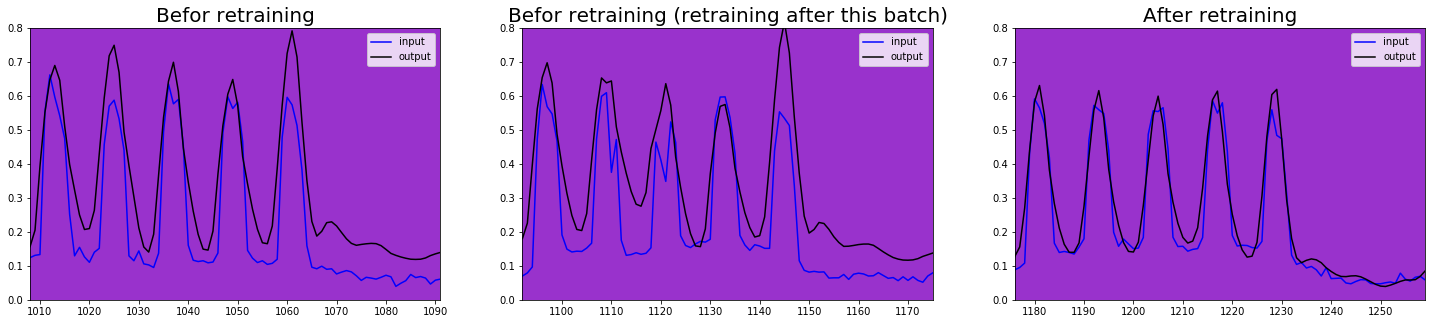

In [29]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
#plt.suptitle("Befor & after retraining")
data[84*12:84*13].plot(ax=ax0,color=['blue','black'])
data[84*13:84*14].plot(ax=ax1,color=['blue','black'])
data[84*14:84*15].plot(ax=ax2,color=['blue','black'])
ax0.set_facecolor('darkorchid')
ax1.set_facecolor('darkorchid')
ax2.set_facecolor('darkorchid')
ax0.set_title("Befor retraining", fontsize=20)
ax1.set_title("Befor retraining (retraining after this batch)", fontsize=20)
ax2.set_title("After retraining", fontsize=20)
ax0.set_ylim(0,0.8)
ax1.set_ylim(0,0.8)
ax2.set_ylim(0,0.8)